In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Two Point Boundary Value Problems

Consider a Poisson equation:
    
$$u^{\prime\prime} = f$$

on $[0, 1]$.  This is a second-order ODE, so it requires 2 boundary conditions.  Let's take:

\begin{align*}
u(0) &= a \\
u(1) &= b
\end{align*}

These are at opposite ends on the domain&mdash;this is not an initial value problem.  The methods we used thus far do not work on this.

Later we'll see how to apply relaxation methods to this problem.  Now we'll consider *shooting*.

Let's rewrite this as a system:

\begin{align*}
y_1 &= u \\
y_2 &= u^\prime
\end{align*}

Let's take the left boundary conditions as:

\begin{align*}
y_1(0) &= a \\
y_2(0) &= \eta 
\end{align*}

What is $\eta$?  This is a parameter that we will adjust to make the solution yield $y(1) = b$ at the end of integration.  We'll all the solution for a particular value of $\eta$ $y^{(\eta)}(x)$.

Shooting algorithm:

  * Guess $\eta$
  * Iterate:
    * Integrate system to right boundary
    * Use secant method to zero $f(\eta) = b - y_1^{(\eta)}(1)$
    * Correct $\eta$

Example (from Pang):

$$u^{\prime\prime} = -\frac{1}{4} \pi^2 (u + 1)$$

with

\begin{align*}
u(0) &= 0 \\
u(1) &= 1
\end{align*}

This has the analytic solution:

$$u(x) = \cos(\pi x/2) + 2 \sin(\pi x / 2) - 1$$

Here's an implementation that uses RK4.

First the RHS function:

In [12]:
def rhs(y1, y2):
    """ RHS function.  Here y1 = u, y2 = u'
        This means that our original system is:
           y2' = u'' = -0.25*pi**2 (u+1) """

    dy1dx = y2
    dy2dx = -0.25*np.pi**2 * (y1 + 1.0)

    return dy1dx, dy2dx

Now the integrator:

In [13]:
def rk4(y_init, rhs, xl=0.0, xr=1.0, n=100):
    """
    R-K 4 integration: y1_0 and eta are y1(0) and y2(0) rhs is the
    righthand side function xl and xr are the domain limits n
    is the number of integration points (including starting point)

    """
    
    # compute the step size
    h = (xr - xl)/(n-1)

    y1 = np.zeros(n)
    y2 = np.zeros(n)

    # left boundary initialization
    y1[0] = y_init[0]
    y2[0] = y_init[1]

    for m in range(n-1):
        dy1dx_1, dy2dx_1 = rhs(y1[m], y2[m])
        dy1dx_2, dy2dx_2 = rhs(y1[m] + 0.5*h*dy1dx_1, y2[m] + 0.5*h*dy2dx_1)
        dy1dx_3, dy2dx_3 = rhs(y1[m] + 0.5*h*dy1dx_2, y2[m] + 0.5*h*dy2dx_2)
        dy1dx_4, dy2dx_4 = rhs(y1[m] + h*dy1dx_3, y2[m] + h*dy2dx_3)

        y1[m+1] = y1[m] + (h/6.0)*(dy1dx_1 + 2.0*dy1dx_2 + 2.0*dy1dx_3 + dy1dx_4)
        y2[m+1] = y2[m] + (h/6.0)*(dy2dx_1 + 2.0*dy2dx_2 + 2.0*dy2dx_3 + dy2dx_4)

    return y1, y2

and finally the driver:

In [14]:
def solve_bvp(ax=None):
    """shoot from x = 0 to x = 1.  We will do this by selecting a boundary
    value for y2 and use a secant method to adjust it until we reach the
    desired boundary condition at y1(1)"""

    # domain size
    x_left = 0.0
    x_right = 1.0

    # desired right BC, y1(1)
    y1_right_true = 1.0

    # number of integration points
    npts = 32

    # desired tolerance
    eps = 1.e-8

    # initial guess
    y1_0 = 0.0   # this is the correct boundary condition a x = 0
    eta = 0.0   # this is what we will adjust to get the desired y1(1)

    # integrate
    y1_old, y2_old = rk4([y1_0, eta], rhs, xl=0.0, xr=1.0, n=npts)

    if ax:
        x = np.linspace(0.0, 1.0, npts)
        ax.scatter(x, y1_old, label="initial guess", marker="x")

    # new guess -- we don't have any info on how to compute this yet, so
    # just choose something
    eta_m1 = eta   # store the old guess
    eta = -1.0

    # Secant loop
    dy = 1000.0    # fail first time through

    # keep track of iteration for plotting
    iter = 1

    while dy > eps:

        # integrate
        y1, y2 = rk4([y1_0, eta], rhs, xl = 0.0, xr = 1.0, n=npts)

        if ax:
            ax.scatter(x, y1, label=f"iteration {iter}", marker="x")

        # do a Secant method to correct.  Here eta = y2(0) -- our
        # control parameter.  We want to zero:
        #   f(eta) = y1_true(1) - y1^(eta)(1)

        # derivative (for Secant)
        dfdeta = ( (y1_right_true - y1_old[-1]) -
                   (y1_right_true - y1[-1]) ) / (eta_m1 - eta)

        # correction by f(eta) = 0 = f(eta_0) + dfdeta deta
        deta = -(y1_right_true - y1[-1]) / dfdeta

        # store the old guess and correct
        eta_m1 = eta
        eta += deta

        dy = abs(deta)

        y1_old = y1
        y2_old = y2

        iter += 1
        
    return eta, y1, y2

Now we'll run it, making plots along the way.  We'll also show the analytic solution

In [18]:
def analytic(x):
    """ analytic solution """
    return np.cos(np.pi*x/2) + 2.0*np.sin(np.pi*x/2) - 1.0

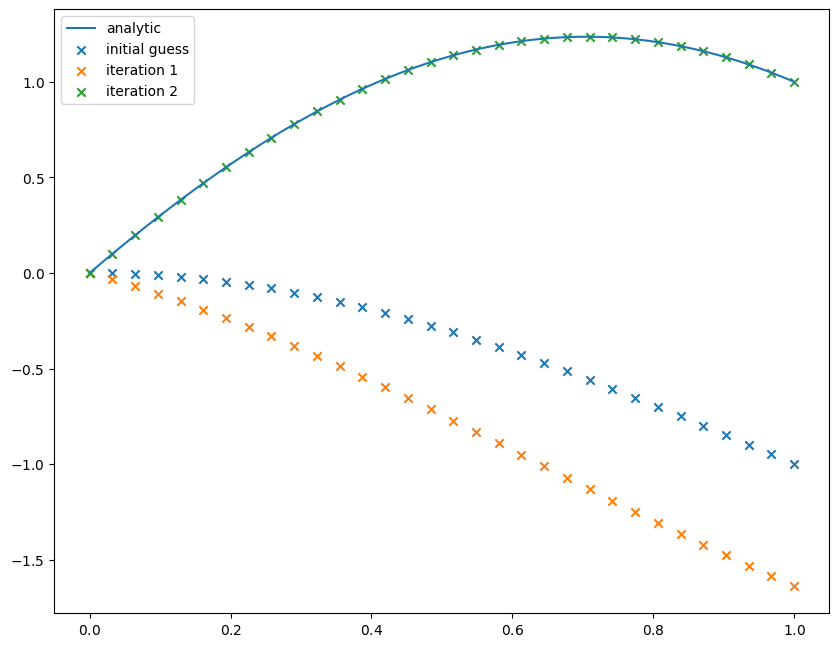

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

eta, y1, y2 = solve_bvp(ax)

x = np.linspace(0, 1, 100)
ax.plot(x, analytic(x), label="analytic")
ax.legend()

References:

* Pang
* Neumann
    